In [1]:
import os

os.environ["NO_ALBUMENTATIONS_UPDATE"] = "1"

import albumentations as A
import cv2 as cv
import matplotlib.pyplot as plt
import torch

from cvnets.yolov1.net import YOLOv1
from cvnets.yolov1.utils import decode_yolo_output, filter_detections
from cvnets.yolov1.voc import VOCDataset

S = 7
B = 2
C = 20
imgsz = 448

In [ ]:
dataset = VOCDataset("~/Documents/Datasets/VOC/", imgsz=448, S=7, B=2, split="val", normalize=False)
dataset.eval()

model = YOLOv1(imgsz=imgsz, S=S, B=B, C=C)
model.load_state_dict(torch.load("./checkpoints/yolov1-voc2012.pt", map_location="cpu", weights_only=True))
model = model.eval()

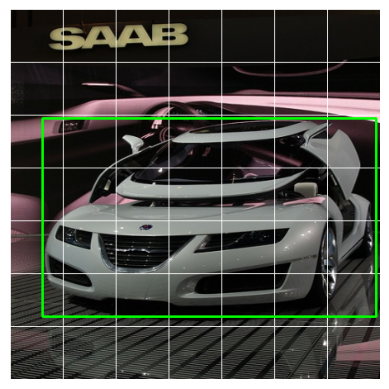

In [129]:
sample = dataset[5]

image = sample.image.permute(1, 2, 0).numpy().astype("uint8")
bboxes = sample.bboxes.numpy()
labels = sample.labels.numpy()

norm = A.Normalize()
image_tensor = norm(image=image)["image"]
image_tensor = torch.as_tensor(image_tensor).permute(2, 0, 1).unsqueeze(0).float()

with torch.inference_mode():
    prediction = model(image_tensor).reshape(1, S, S, 5 * B + C)

cell_size = imgsz // S
for i in range(S):
    for j in range(S):
        cv.rectangle(
            image, (j * cell_size, i * cell_size), ((j + 1) * cell_size, (i + 1) * cell_size), (255, 255, 255), 1
        )

for bbox in bboxes:
    cv.rectangle(image, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 255, 0), 2)

plt.imshow(image)
plt.axis("off")
plt.show()

In [ ]:
xyxys, confs, labels = decode_yolo_output(prediction, imgsz, S, B, C)
xyxys, confs, labels = xyxys.squeeze(), confs.squeeze(), labels.squeeze()
xyxys, confs, labels = filter_detections(xyxys, confs, labels)

img = image.copy()

for bbox in xyxys.numpy():
    cv.rectangle(img, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (255, 0, 0), 2)

plt.imshow(img)
plt.axis("off")
plt.show()